In [1]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import geopandas
import shapely
import cmocean
import pandas

In [2]:
#filename = '/Users/baird/Dropbox/_data_observations/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4-10.2018-05-31T17-55-21ZN.hdf'
file_dir = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/'

In [3]:
file_list = sorted(glob.glob(file_dir+'/*.hdf'))

In [4]:
# ===== open file, pull out specific data set
gdal_file = gdal.Open(file_list[0])
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter

In [5]:
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_tbc_data = gdal_tbc_ds.ReadAsArray()

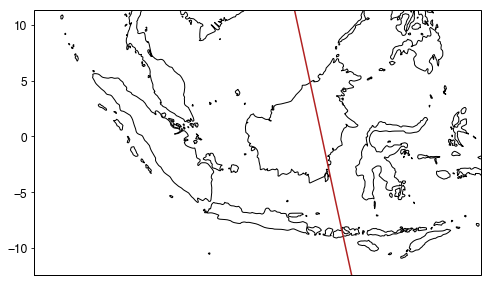

In [6]:
ds = xarray.open_dataset(file_list[0])

lat = ds['Latitude'].values[:,0]
lon = ds['Longitude'].values[:,0]


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

plot multiple at once

# convert lat/lon combos to shapely LineString

In [43]:
track_geom = shapely.geometry.LineString(zip(lon,lat))
type(track_geom)

shapely.geometry.linestring.LineString

# Read in natural Earth data

Read in country shape file using geopandas  
download data from Natural Earth:  https://www.naturalearthdata.com/

In [45]:
countries = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_0_countries')

#extract shapefile info for a single country
countries.crs
countries.geometry.bounds.head()
indonesia = countries[countries['ADMIN']=='Indonesia']
#indonesia.geom_type
#type(indonesia)

In [46]:
# loop through each country (country name is SOVEREIGNT, look up via countries.head())
# store in list with country name, row number
country_rownumbers = {k: i for i,k in enumerate(countries.SOVEREIGNT)}
# store a list of country shapes
countries_shapes = [(shape,n) for n,shape in enumerate(countries.geometry)]

# open states

In [47]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

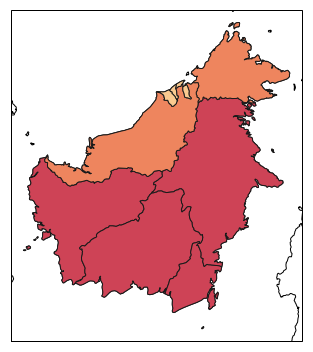

In [48]:
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8.5,5))

ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(resolution='10m')

ax.add_geometries(states_indo_kalimantan.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.5), edgecolor='0.1')
ax.add_geometries(states_malay_borneo.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.3), edgecolor='0.1')
ax.add_geometries(states_brunei.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.1), edgecolor='0.1')

minx_min = numpy.min(states_indo_kalimantan.geometry.bounds['minx'])
maxx_max = numpy.max(states_malay_borneo.geometry.bounds['maxx'])
miny_min = numpy.min(states_indo_kalimantan.geometry.bounds['miny'])
maxy_max = numpy.max(states_malay_borneo.geometry.bounds['maxy'])

offset = 0.5
ax.set_extent([minx_min-offset,maxx_max+offset,miny_min-offset,maxy_max+offset])

fig.tight_layout()

concatenate all the states plotted above and take their union

(index 15 corresponds to the big Borneo mainland)

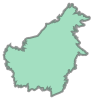

In [49]:
borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union

list(borneo_gdf_union.geoms)[15]

extract this

In [53]:
borneo_main_geom = borneo_gdf_union.geoms[15]

In [54]:
print(type(track_geom))
print(type(borneo_main_gdf))

<class 'shapely.geometry.linestring.LineString'>
<class 'shapely.geometry.polygon.Polygon'>


In [82]:
track_indo_geom = track_geom.intersection(borneo_main_geom)

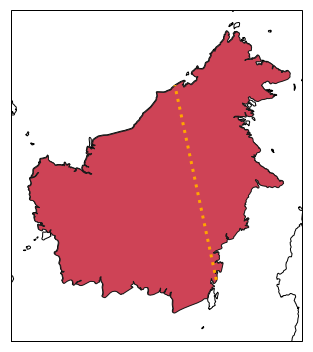

In [85]:
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8.5,5))

ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(resolution='10m')

ax.add_geometries([borneo_main_geom], crs=map_proj, facecolor=cmocean.cm.matter(0.5), edgecolor='0.1')

minx_min = numpy.min(states_indo_kalimantan.geometry.bounds['minx'])
maxx_max = numpy.max(states_malay_borneo.geometry.bounds['maxx'])
miny_min = numpy.min(states_indo_kalimantan.geometry.bounds['miny'])
maxy_max = numpy.max(states_malay_borneo.geometry.bounds['maxy'])

ax.add_geometries(track_indo_geom, crs=map_proj, facecolor='None', edgecolor='orange', linewidth=3, linestyle=':')

offset = 0.5
ax.set_extent([minx_min-offset,maxx_max+offset,miny_min-offset,maxy_max+offset])

fig.tight_layout()

In [86]:
type(track_indo_geom)

shapely.geometry.multilinestring.MultiLineString

In [87]:
track_indo_geom.length

7.916642544606901

In [90]:
type(track_geom)

shapely.geometry.linestring.LineString

In [91]:
print(list(track_geom.coords)[:10])

[(138.92745971679688, -65.68175506591797), (138.88674926757812, -65.6396484375), (138.84593200683594, -65.59764099121094), (138.80540466308594, -65.5558090209961), (138.7650909423828, -65.51347351074219), (138.72476196289062, -65.47113037109375), (138.6844940185547, -65.4288330078125), (138.64434814453125, -65.38661193847656), (138.6042022705078, -65.34445190429688), (138.5640106201172, -65.30204010009766)]


In [92]:
track_indo_geom.bounds

(114.70519639651927,
 -2.8824958739188804,
 116.35666331076035,
 4.862155873587055)

In [94]:
list(track_indo_geom.geoms)

In [101]:
list(track_indo_geom.geoms[0].coords)[:10]

[(116.35666331076035, -2.8824958739188804),
 (116.3547134399414, -2.8733270168304443),
 (116.34498596191406, -2.828329563140869),
 (116.33528137207031, -2.783463954925537),
 (116.32574462890625, -2.738548994064331),
 (116.31639099121094, -2.69353985786438),
 (116.30668640136719, -2.648712158203125),
 (116.2981776944089, -2.6088142677515735)]

In [102]:
list(track_indo_geom.geoms[1].coords)[:10]

[(116.29772999427176, -2.606714972157712),
 (116.2970962524414, -2.603743314743042),
 (116.28748321533203, -2.5587339401245117),
 (116.27777862548828, -2.5137205123901367),
 (116.26827239990234, -2.468475580215454),
 (116.25874328613281, -2.423393726348877),
 (116.24913787841797, -2.378446578979492),
 (116.23944091796875, -2.3336126804351807),
 (116.22989654541016, -2.2885940074920654),
 (116.22039031982422, -2.2435803413391113)]

In [119]:
LIST = list(track_indo_geom.geoms[0].coords) + list(track_indo_geom.geoms[1].coords)

In [120]:
mask = [latlon in LIST for latlon in list(zip(lon,lat))]

In [121]:
sum(mask)

173

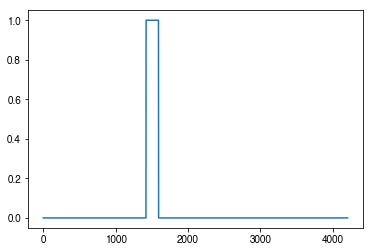

In [122]:
mp.plot(mask)